In [1]:
# TODO Test LSTM for Feature Extraction
# Test both weighted and unweighted class approaches for better CV-LB estimation.
# Test PCA After automated feature extractor.
# Look at the feature importances of the autogenerated features.
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from matplotlib import rcParams
%matplotlib inline
le = preprocessing.LabelEncoder()
import re
import warnings
from sklearn.metrics import accuracy_score, confusion_matrix
import featuretools as ft 
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
from sklearn.model_selection import StratifiedKFold, GroupShuffleSplit
from sklearn.ensemble import RandomForestClassifier
import gc
from tsfresh import extract_relevant_features
from sklearn.decomposition import PCA

In [2]:
'''
def plot_confusion_matrix(truth, pred, classes, normalize=False, title=''):
    cm = confusion_matrix(truth, pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix', size=15)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.tight_layout()
'''

'\ndef plot_confusion_matrix(truth, pred, classes, normalize=False, title=\'\'):\n    cm = confusion_matrix(truth, pred)\n    if normalize:\n        cm = cm.astype(\'float\') / cm.sum(axis=1)[:, np.newaxis]\n    \n    plt.figure(figsize=(10, 10))\n    plt.imshow(cm, interpolation=\'nearest\', cmap=plt.cm.Blues)\n    plt.title(\'Confusion matrix\', size=15)\n    plt.colorbar(fraction=0.046, pad=0.04)\n    tick_marks = np.arange(len(classes))\n    plt.xticks(tick_marks, classes, rotation=45)\n    plt.yticks(tick_marks, classes)\n\n    fmt = \'.2f\' if normalize else \'d\'\n    thresh = cm.max() / 2.\n    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):\n        plt.text(j, i, format(cm[i, j], fmt),\n                 horizontalalignment="center",\n                 color="white" if cm[i, j] > thresh else "black")\n\n    plt.ylabel(\'True label\')\n    plt.xlabel(\'Predicted label\')\n    plt.grid(False)\n    plt.tight_layout()\n'

In [3]:
def plot_feature_class_distribution(classes,tt, features,a=5,b=2):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(a,b,figsize=(16,24))

    for feature in features:
        i += 1
        plt.subplot(a,b,i)
        for clas in classes:
            ttc = tt[tt['surface']==clas]
            sns.kdeplot(ttc[feature], bw=0.5,label=clas)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show();

In [4]:
def balanced_cv(conf_mat):
    assert len(conf_mat.shape) == 2
    rows, columns = conf_mat.shape
    intra_class_scores = np.zeros((1, columns))
    column_sums = np.sum(conf_mat, axis=0)
    for c in range(columns):
        intra_class_scores[0][c] = float(conf_mat[c][c])/column_sums[c]
        
    balanced_score = np.mean(intra_class_scores)
    return balanced_score
'''
def lb_cv(conf_mat):
    assert len(conf_mat.shape) == 2
    rows, columns = conf_mat.shape
    intra_class_scores = np.zeros((1, columns))
    column_sums = np.sum(conf_mat, axis=0)
    for c in range(columns):
        intra_class_scores[0][c] = float(conf_mat[c][c])/column_sums[c]
        
    balanced_score = np.mean(intra_class_scores)
    return balanced_score
'''

'\ndef lb_cv(conf_mat):\n    assert len(conf_mat.shape) == 2\n    rows, columns = conf_mat.shape\n    intra_class_scores = np.zeros((1, columns))\n    column_sums = np.sum(conf_mat, axis=0)\n    for c in range(columns):\n        intra_class_scores[0][c] = float(conf_mat[c][c])/column_sums[c]\n        \n    balanced_score = np.mean(intra_class_scores)\n    return balanced_score\n'

In [5]:
def plot_feature_distribution(df1, df2, label1, label2, features,a=2,b=5):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(a,b,figsize=(17,9))

    for feature in features:
        i += 1
        plt.subplot(a,b,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show();

In [6]:
data = pd.read_csv('X_train.csv')
target = pd.read_csv('y_train.csv')
sampl = pd.read_csv('sample_submission.csv')
test = pd.read_csv('X_test.csv')

In [7]:
totalt = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([totalt, percent], axis=1, keys=['Total', 'Percent'])
# missing_data.head(5)

In [8]:
totalt = test.isnull().sum().sort_values(ascending=False)
percent = (test.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([totalt, percent], axis=1, keys=['Total', 'Percent'])
# missing_data.head(5)

In [9]:
# data.describe()

In [10]:
# target.describe()

In [11]:
# test.describe()

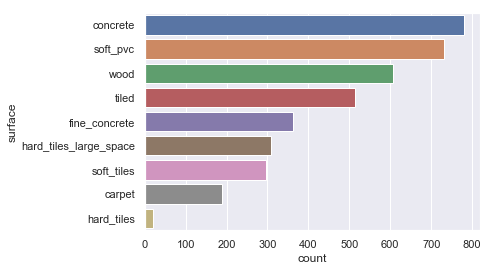

In [12]:
sns.set(style='darkgrid')
sns.countplot(y = 'surface',
              data = target,
              order = target['surface'].value_counts().index)
plt.show()

In [13]:
data.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [14]:
#Label Encoding
target['surface'] = le.fit_transform(target['surface'])

In [15]:
# print(data['row_id'].dtype)
data.drop(['row_id'],axis=1)
data = data.astype('float64')
test.drop(['row_id'],axis=1)
test = test.astype('float64')
'''
data[data['series_id'] == 0].plot(subplots=True, sharex=True, figsize=(10,10))
plt.show()
'''
data = extract_relevant_features(data, target['surface'], column_id='series_id', column_sort='measurement_number')
# data = extract_features(data, column_id="series_id", column_sort="measurement_number")
test = extract_features(test, column_id="series_id", column_sort="measurement_number")

Feature Extraction:   0%|                                                                       | 0/10 [00:00<?, ?it/s]

TypeError: Cannot cast array data from dtype('float64') to dtype('<U32') according to the rule 'safe'

In [ ]:
impute(data)
test = test[data.columns]

In [ ]:
print(data.shape)
print(test.shape)

In [ ]:
impute(test)

In [ ]:
test.head()

In [ ]:
data.head()

In [ ]:
'''
pca = PCA(n_components=100)
datapca = pca.fit_transform(data.values)
testpca = pca.transform(test.values)
print(datapca.shape)
print(testpca.shape)
data_new = pd.DataFrame(datapca)
test_new = pd.DataFrame(testpca)
data_new.head()
test_new.head()
'''

In [ ]:
split_count = 5
folds = StratifiedKFold(n_splits=5, shuffle=True)
# folds = GroupShuffleSplit(n_splits=split_count)

In [ ]:
predicted = np.zeros((test.shape[0],9))
# measured= np.zeros((data.shape[0]))
score = 0
balanced_cv_sum = 0
# Balanced model training gives slightly worse results on pubLB.
model = RandomForestClassifier(n_estimators=200, class_weight = 'balanced')
# model = XGBClassifier(tree_method='gpu_hist')
# model = LGBMClassifier(device='gpu')
for times, (trn_idx, val_idx) in enumerate(folds.split(data.values,target['surface'].values)):
    model.fit(data.iloc[trn_idx],target['surface'][trn_idx])
    # measured[val_idx] = model.predict(data.iloc[val_idx])
    # predicted += model.predict_proba(test)/folds.n_splits
    score += model.score(data.iloc[val_idx],target['surface'][val_idx])
    print("Fold: {} score: {}".format(times,model.score(data.iloc[val_idx],target['surface'][val_idx])))
    cm = confusion_matrix(model.predict(data.iloc[val_idx]), target['surface'].iloc[val_idx])
    plt.figure()
    sns.heatmap(cm, annot=True, cmap="YlOrBr")
    balscore = balanced_cv(cm)
    print('balanced cv score', balscore)
    balanced_cv_sum +=balscore
    gc.collect()
print('Avg Accuracy', score / folds.n_splits)
print('Avg Balanced Accuracy', balanced_cv_sum / folds.n_splits)

In [ ]:
model.fit(data, target['surface'])
predicted = model.predict_proba(test)
sampl['surface'] = le.inverse_transform(predicted.argmax(axis=1))
sampl.to_csv('submission.csv', index=False)
# sampl.head()